In [1]:
import numpy as np
from tqdm import tqdm
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image

from sequitur.models import CONV_LSTM_AE, LSTM_AE

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as T
from torch.utils.data import Dataset, random_split, DataLoader
import torch.nn.functional as F

import json
import os
import random
from collections import OrderedDict

Идея в том, чтобы принимать картинку за одного и того же человека, если их вектора-эмбеддинги близки.  
Получать эмбеддинг картинки, к этому вектору конкатенировать положение картинки на кадре из видео.

In [2]:
annotations2vid = {
    "../alphapose_res/0756_alpha.json" : "../original_vids/0756-30fps.mp4",
    "../alphapose_res/0912_alpha.json" : "../original_vids/0912-30fps.mp4",
    "../alphapose_res/1043_alpha.json" : "../original_vids/1043-30fps.mp4",
    "../alphapose_res/1156_alpha.json" : "../original_vids/1156-30fps.mp4",
    "../alphapose_res/1237_alpha.json" : "../original_vids/1237-30fps.mp4",
    "../alphapose_res/20240320_alpha.json" : "../original_vids/20240320_193441-30fps.mp4",
    "../alphapose_res/irimi_tenkan_kps.json" : "../irimi_tenkan_mistakes_crop.mp4",
    "../alphapose_res/paths_0220.json" : "../original_vids/20230220_2_track-30fps.mp4",
    "../alphapose_res/selection_192514.json" : "../original_vids/selection_20240219_192514-30fps.mp4",
    "../alphapose_res/selection_192815.json" : "../original_vids/selection_20240214_192815-30fps.mp4",
    "../alphapose_res/ta_tracking.json" : "../tsugi_ashi_mistakes_crop.mp4",
    "../alphapose_res/utmt_kps.json" : "../ushiro_tenkan_mae_tenkan_mistakes_crop.mp4"
}

EMB_DIM = 28

# Отслеживание с SSIM или PSNR

Все box'ы нужны только для визуализации

In [16]:
def resize_person_image(im:np.ndarray, side:int=224):
    try:
        tmp_pil = Image.fromarray(im)
        resized = tmp_pil.resize((side, side))
        return np.array(resized)
    except:
        return np.ones((224, 224, 3))        

# https://docs.opencv.org/3.4/d5/dc4/tutorial_video_input_psnr_ssim.html
def getPSNR(I1, I2):
    if I1.shape != I2.shape: # insure that sizes are the same
        I1 = resize_person_image(I1)
        I2 = resize_person_image(I2)  
    s1 = cv.absdiff(I1, I2) #|I1 - I2|
    s1 = np.float32(s1) # cannot make a square on 8 bits
    s1 = s1 * s1 # |I1 - I2|^2
    sse = s1.sum() # sum elements per channel
    if sse <= 1e-10: # sum channels
        return 0 # for small values return zero
    shape = I1.shape
    mse = 1.0 * sse / (shape[0] * shape[1] * shape[2])
    psnr = 10.0 * np.log10((255 * 255) / mse)
    return psnr
    
def getMSSISM(i1, i2):
    if i1.shape != i2.shape: # insure that sizes are the same
        i1 = resize_person_image(i1)
        i2 = resize_person_image(i2)    
    C1 = 6.5025
    C2 = 58.5225
    # INITS
    I1 = np.float32(i1) # cannot calculate on one byte large values
    I2 = np.float32(i2)
    I2_2 = I2 * I2 # I2^2
    I1_2 = I1 * I1 # I1^2
    I1_I2 = I1 * I2 # I1 * I2
    # END INITS
    # PRELIMINARY COMPUTING
    mu1 = cv.GaussianBlur(I1, (11, 11), 1.5)
    mu2 = cv.GaussianBlur(I2, (11, 11), 1.5)
    mu1_2 = mu1 * mu1
    mu2_2 = mu2 * mu2
    mu1_mu2 = mu1 * mu2
    sigma1_2 = cv.GaussianBlur(I1_2, (11, 11), 1.5)
    sigma1_2 -= mu1_2
    sigma2_2 = cv.GaussianBlur(I2_2, (11, 11), 1.5)
    sigma2_2 -= mu2_2
    sigma12 = cv.GaussianBlur(I1_I2, (11, 11), 1.5)
    sigma12 -= mu1_mu2
    t1 = 2 * mu1_mu2 + C1
    t2 = 2 * sigma12 + C2
    t3 = t1 * t2 # t3 = ((2*mu1_mu2 + C1).*(2*sigma12 + C2))
    t1 = mu1_2 + mu2_2 + C1
    t2 = sigma1_2 + sigma2_2 + C2
    t1 = t1 * t2 # t1 =((mu1_2 + mu2_2 + C1).*(sigma1_2 + sigma2_2 + C2))
    ssim_map = cv.divide(t3, t1) # ssim_map = t3./t1;
    mssim = cv.mean(ssim_map) # mssim = average of ssim map
    
    # my change - return just 1 val
    # no alpha channel
    return np.mean(mssim[:3]) # mssim

def update_person_box_similarity(prev_images:dict, prev_boxes:dict, newly_images:list, newly_boxes:list, ssim_threshold:float=0.5):
    new_images_index = dict()
    new_box_index = dict()
    sims = dict()
    for box_idx, box in enumerate(newly_images):
        potential_index = dict()
        for idx in prev_images:
            similarity = getMSSISM(box, prev_images[idx]) #getPSNR(box, prev_images[idx])
            if idx in new_images_index and (sims[idx] >= similarity):
                continue  
            if similarity >= ssim_threshold : #same person
                potential_index[idx] = similarity
        if len(potential_index) > 0:
            max_index = max(potential_index, key=potential_index.get)
            new_images_index[max_index] = box
            sims[max_index] = potential_index[max_index]
            new_box_index[max_index] = newly_boxes[box_idx]
        else: # found new person
            new_max_idx = max(prev_images) + 1
            new_images_index[new_max_idx] = box
            sims[new_max_idx] = 1
            new_box_index[new_max_idx] = newly_boxes[box_idx]
    for idx in prev_images:
        if not (idx in new_images_index): #not in new_box_index either
            new_images_index[idx] = prev_images[idx]
            new_box_index[idx] = prev_boxes[idx]
    return new_images_index, new_box_index

def vis_box_tracking(image, boxes:dict, colors:np.ndarray) -> np.ndarray:
    for box_key in boxes:
        color = (int(colors[box_key, 0]), int(colors[box_key, 1]), int(colors[box_key, 2]))
        bbox = boxes[box_key]
        start_point = int(bbox[0]), int(bbox[1])
        end_point = int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3])
        cv.rectangle(image, start_point, end_point, color, 2)
        text_location = (10 + int(bbox[0]), 20 + int(bbox[1]))
        cv.putText(image, str(box_key), text_location, cv.FONT_HERSHEY_PLAIN, 1, color, 3)
    return image

In [17]:
codec_code = cv.VideoWriter.fourcc(*'h264')
writer = cv.VideoWriter("../ta_tracking_presentation.mp4", codec_code, 30.0, (1280, 720))
writer.isOpened()

True

In [18]:
colors = np.random.default_rng().integers(0, 256, (1000, 3), dtype='uint8')
vidcap = cv.VideoCapture("../tsugi_ashi_mistakes_crop.mp4")
fps = vidcap.get(cv.CAP_PROP_FPS)
total_frames = int(vidcap.get(cv.CAP_PROP_FRAME_COUNT))

vid_width = vidcap.get(cv.CAP_PROP_FRAME_WIDTH)
vid_height = vidcap.get(cv.CAP_PROP_FRAME_HEIGHT)

current_frame = 0
success,frame = vidcap.read()
if not success:
    print("error in video", vid_path)
with open("../alphapose_res/ta_tracking.json", "r") as ann_file:
    anns = json.load(ann_file)
past_frame_identified_people = None
past_frame_boxes = None
cur_frame_people = []
cur_frame_boxes = []
for person in tqdm(anns):
    if person['image_id'] > current_frame:
        # print("cur", cur_frame_boxes)
        # print("past", past_frame_boxes)
        # if current_frame + 1 == 5: break
        if past_frame_identified_people and past_frame_boxes:
            past_frame_identified_people, past_frame_boxes = update_person_box_similarity(
                past_frame_identified_people, past_frame_boxes,
                cur_frame_people, cur_frame_boxes, 0)
        else:
            past_frame_identified_people = {idx:pic for idx, pic in enumerate(cur_frame_people)}
            past_frame_boxes = {idx:pic for idx, pic in enumerate(cur_frame_boxes)}
        annotated_img = vis_box_tracking(frame, past_frame_boxes, colors)
        writer.write(annotated_img)
        
        success,frame = vidcap.read()
        if not success:
            print("error in video")
            break
        current_frame += 1
        cur_frame_people = []
        cur_frame_boxes = []
    person_bbox = np.array(list(map(round, person['box'])))
    y, x, h, w = person_bbox
    person_img = frame[x:x + w, y:y + h]
    #person_scaled_bbox = np.array([x/vid_width, y/vid_height, w/vid_width, h/vid_height])
    #cur_frame_people.append((person_img, person_scaled_bbox))
    cur_frame_boxes.append(person_bbox)
    cur_frame_people.append(person_img)
vidcap.release()
writer.release()

 63%|████████████████████████████████████████████████▋                            | 6670/10557 [04:37<02:41, 24.05it/s]


error: OpenCV(4.6.0) C:\b\abs_f8n1j3l9l0\croot\opencv-suite_1691622637237\work\modules\imgproc\src\smooth.dispatch.cpp:617: error: (-215:Assertion failed) !_src.empty() in function 'cv::GaussianBlur'


# Отслеживание с ML

## Подготовка данных

Пока на 1 видео, так как чтение всех видео из списка тормозит мой компьютер до троттлинга.

BoundingBox(origin_x, origin_y, width, height)

In [4]:
def read_people_images(annotations_path, vid_path):
    people_imgs_coordinates = []
    print("Processing", annotations_path)
    with open(annotations_path, "r") as ann_file:
        anns = json.load(ann_file)
        
    vidcap = cv.VideoCapture(vid_path)
    if not vidcap.isOpened():
        print("error in video", vid_path)
        return people_imgs_coordinates
    vid_width = vidcap.get(cv.CAP_PROP_FRAME_WIDTH)
    vid_height = vidcap.get(cv.CAP_PROP_FRAME_HEIGHT)
    current_frame = 0
    success,frame = vidcap.read()
    if not success:
        print("error in video", vid_path)
        vidcap.release()
        return people_imgs_coordinates
    #cur_frame_people = []
    for person in tqdm(anns):
        if person['image_id'] > current_frame:
            success,frame = vidcap.read()
            if not success:
                print("error in video", vid_path)
                break
            current_frame += 1
            # people_imgs_coordinates.append(cur_frame_people)
            # cur_frame_people = []
        person_bbox = np.array(list(map(round, person['box'])))
        y, x, h, w = person_bbox
        person_img = frame[x:x + w, y:y + h]
        person_scaled_bbox = np.array([x/vid_width, y/vid_height, w/vid_width, h/vid_height])
        people_imgs_coordinates.append((person_img, person_scaled_bbox))
        #cur_frame_people.append(person_img)
    vidcap.release()
    return people_imgs_coordinates

In [7]:
frame_people = read_people_images("../alphapose_res/0912_alpha.json", "../original_vids/0912-30fps.mp4")
len(frame_people)

Processing ../alphapose_res/0912_alpha.json


100%|██████████████████████████████████████████████████████████████████████████| 13726/13726 [00:04<00:00, 3320.22it/s]


13726

In [5]:
class NNTrackingDataset(Dataset):
    def __init__(self, frame_people:list, transform):
        self.transform = transform
        self.images, self.boxes = zip(*frame_people)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.fromarray(self.images[idx])
        return self.transform(img)

    def img_with_box_at(idx):
        return self.__getitem__(idx), self.boxes[idx]

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

train_tforms = T.Compose([
    T.Resize([224, 224]),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std)
])

val_tforms = T.Compose([
    T.Resize([224, 224]),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std)
])

In [8]:
train_frac = 0.8
val_frac = 0.2
#test_frac = 0.2

train_imgs = []
test_imgs = []
val_imgs = []
for info in frame_people:
    rval = random.random()
    if rval <= train_frac:
        train_imgs.append(info)
    # elif rval <= (train_frac + test_frac):
    #     test_imgs.append(info)
    else:
        val_imgs.append(info)

print("Train count", len(train_imgs))
#print("Test count", len(test_imgs))
print("Val count", len(val_imgs))

Train count 10925
Val count 2801


In [10]:
train_ds = NNTrackingDataset(train_imgs, train_tforms)
val_ds = NNTrackingDataset(val_imgs, val_tforms)
#test_ds = NNTrackingDataset(test_imgs, val_tforms)
train_ds[0].shape

torch.Size([3, 224, 224])

In [11]:
# setting batch size for Dataloader to load the data batch by batch
batch_size = 32
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size, shuffle=False)
#test_loader = DataLoader(test_ds, 1, shuffle=False)

## Модель

Код для обучения и архитектуры модели взят из:

https://pyimagesearch.com/2023/07/17/implementing-a-convolutional-autoencoder-with-pytorch/

In [12]:
class Encoder(nn.Module):
    def __init__(self, channels, embedding_dim):
        super(Encoder, self).__init__()
        # define convolutional layers
        self.conv1 = nn.Conv2d(channels, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        # variable to store the shape of the output tensor before flattening
        # the features, it will be used in decoders input while reconstructing
        self.shape_before_flattening = None
        # compute the flattened size after convolutions
        flattened_size = 128 * 28 * 28 
        # define fully connected layer to create embeddings
        self.fc = nn.Linear(flattened_size, embedding_dim)
    def forward(self, x):
        # apply ReLU activations after each convolutional layer
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        # store the shape before flattening
        self.shape_before_flattening = x.shape[1:]
        # flatten the tensor
        x = x.view(x.size(0), -1)
        # apply fully connected layer to generate embeddings
        x = self.fc(x)
        return x

class Decoder(nn.Module):
    def __init__(self, embedding_dim, shape_before_flattening, channels):
        super(Decoder, self).__init__()
        # define fully connected layer to unflatten the embeddings
        self.fc = nn.Linear(embedding_dim, np.prod(shape_before_flattening))
        # store the shape before flattening
        self.reshape_dim = shape_before_flattening
        # define transpose convolutional layers
        self.deconv1 = nn.ConvTranspose2d(
            128, 128, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv2 = nn.ConvTranspose2d(
            128, 64, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        self.deconv3 = nn.ConvTranspose2d(
            64, 32, kernel_size=3, stride=2, padding=1, output_padding=1
        )
        # define final convolutional layer to generate output image
        self.conv1 = nn.Conv2d(32, channels, kernel_size=3, stride=1, padding=1)
    def forward(self, x):
        # apply fully connected layer to unflatten the embeddings
        x = self.fc(x)
        # reshape the tensor to match shape before flattening
        x = x.view(x.size(0), *self.reshape_dim)
        # apply ReLU activations after each transpose convolutional layer
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        # apply sigmoid activation to the final convolutional layer to generate output image
        x = torch.sigmoid(self.conv1(x)) 
        #x = F.tanh(self.conv1(x))
        return x

## Обучение

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10
print(device)
encoder = Encoder(channels=3, embedding_dim=EMB_DIM).to(device)
# pass the dummy input through the encoder and
# get the output (encoded representation)
dummy_input = torch.rand(1, 3, 224, 224)
enc_out = encoder(dummy_input.to(device))
# get the shape of the tensor before it was flattened in the encoder
shape_before_flattening = encoder.shape_before_flattening
# create a decoder instance with the specified embedding dimensions,
# shape before flattening, and channels
# then move it to the device (CPU or GPU) specified in the config
decoder = Decoder(EMB_DIM, shape_before_flattening, 3).to(device)
# instantiate loss, optimizer, and scheduler

cuda


In [14]:
inprogress_metrics = {"MAE":F.l1_loss} #, "MSE":F.mse_loss

def calc_metrics(preds, targets, inprogress_metrics):
    report = dict()
    for metric in inprogress_metrics:
        metric_func = inprogress_metrics[metric]
        mval = metric_func(preds, targets)
        report[metric] = round(mval.item(), 3)
    return report

def print_report(loss_value, metric_vals, beginning):
    addition = []
    for km in metric_vals:
        formatteds = f"{km}: {metric_vals[km]} "
        addition.append(formatteds)    
    print(beginning, "Loss:", loss_value, "".join(addition))

def train_one_epoch(model, loader, criterion, optimizer, epoch_num):
    model.train()
    running_loss = 0.0
    running_metrics = {k:0.0 for k in inprogress_metrics}
    for batch_idx, data in tqdm(enumerate(loader), total=len(loader), desc=f"Epoch {epoch_num}"):
        # move the data to the device (GPU or CPU)
        data = data.to(device)
        # reset the gradients of the optimizer
        optimizer.zero_grad()
        # forward pass: encode the data and decode the encoded representation
        #encoded = encoder(data)
        decoded = model(data) #decoder(encoded)
        # compute the reconstruction loss between the decoded output and
        # the original data
        loss = criterion(decoded, data)
        # backward pass: compute the gradients
        loss.backward()
        # update the model weights
        optimizer.step()
        # accumulate the loss for the current batch
        running_loss += loss.item()
        metrics = calc_metrics(decoded, data, inprogress_metrics)
        for m in metrics:
            running_metrics[m] += metrics[m]
    # compute the average training loss for the epoch
    train_loss = running_loss / len(loader)
    train_metrics = {k:(running_metrics[k] / len(loader)) for k in running_metrics}
    print_report(train_loss, train_metrics, "Train|")

    res = dict(train_metrics)
    res["loss"] = train_loss
    return res

def evaluate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    running_metrics = {k:0.0 for k in inprogress_metrics}
    with torch.no_grad():
        for i, data in enumerate(loader):
            data = data.to(device)
            #encoded = encoder(data)
            decoded = model(data) #decoder(encoded)
            loss = criterion(decoded, data)
            running_loss += loss.item()
            metrics = calc_metrics(decoded, data, inprogress_metrics)
            for m in metrics:
                running_metrics[m] += metrics[m]
    l = running_loss / len(loader)
    scores = {k:(running_metrics[k] / len(loader)) for k in running_metrics}
    print_report(l, scores, "Valid|")
    
    res = dict(scores)
    res["loss"] = l
    return res

In [17]:
train_history = {n:[] for n in (list(inprogress_metrics.keys())+["loss"])}
val_history = {n:[] for n in (list(inprogress_metrics.keys())+["loss"])}

model = nn.Sequential(OrderedDict([
    ('encoder', Encoder(channels=3, embedding_dim=EMB_DIM)),
    ('decoder', Decoder(EMB_DIM, shape_before_flattening, 3))
])).to(device)
criterion = nn.MSELoss() #nn.BCELoss() # MSE, MAE
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.1, patience=2, verbose=True
)

for epoch in range(epochs):
    #print(f"Epoch: {epoch + 1}/{epochs}")
    tvals = train_one_epoch(model, train_loader, criterion, optimizer, epoch)
    vvals = evaluate(model, val_loader, criterion)
    for k in tvals:
        train_history[k].append(tvals[k])
        val_history[k].append(vvals[k])
    # adjust learning rate based on the validation loss
    scheduler.step(vvals["loss"])

Epoch 0: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:30<00:00, 11.09it/s]


Train| Loss: 0.5936874315926903 MAE: 0.5836461988304092 
Valid| Loss: 0.5252194357189265 MAE: 0.5289090909090909 


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:29<00:00, 11.77it/s]


Train| Loss: 0.5143085541258081 MAE: 0.5200467836257306 
Valid| Loss: 0.5123736076056957 MAE: 0.5161818181818181 


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:29<00:00, 11.77it/s]


Train| Loss: 0.5057883081380387 MAE: 0.5117309941520469 
Valid| Loss: 0.5066387338394468 MAE: 0.5102159090909093 


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:29<00:00, 11.72it/s]


Train| Loss: 0.5007353372741163 MAE: 0.5065438596491226 
Valid| Loss: 0.5034808811138977 MAE: 0.5068636363636364 


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:29<00:00, 11.76it/s]


Train| Loss: 0.4965782753731075 MAE: 0.5023128654970765 
Valid| Loss: 0.5006038434803486 MAE: 0.5030454545454545 


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:29<00:00, 11.69it/s]


Train| Loss: 0.493856961179895 MAE: 0.4993128654970764 
Valid| Loss: 0.4984089925207875 MAE: 0.5012954545454545 


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:29<00:00, 11.70it/s]


Train| Loss: 0.49106391907086844 MAE: 0.49632748538011706 
Valid| Loss: 0.49634198675101454 MAE: 0.49973863636363625 


Epoch 7: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:29<00:00, 11.73it/s]


Train| Loss: 0.4887007541126675 MAE: 0.49388304093567253 
Valid| Loss: 0.49515291167931125 MAE: 0.4976477272727273 


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:29<00:00, 11.48it/s]


Train| Loss: 0.48722885775635816 MAE: 0.4920672514619881 
Valid| Loss: 0.49359121749346907 MAE: 0.49550000000000016 


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████| 342/342 [00:29<00:00, 11.70it/s]


Train| Loss: 0.48501139234381113 MAE: 0.48985380116959065 
Valid| Loss: 0.4923143024471673 MAE: 0.49440909090909096 


In [27]:
# displaying losses
def plot_metrics(train_hist:dict, val_hist:dict):
    metrics_name = [metr_name for metr_name in train_hist if metr_name!="loss"]
    plot_counts = len(metrics_name)
    fig, axs = plt.subplots(1, len(metrics_name), figsize=(4, 2.5), squeeze=False)
    for idx, mname in enumerate(metrics_name):
        train_mvals = train_hist[mname]
        val_mvals = val_hist[mname]
        axs[0, idx].plot(train_mvals, '-b')
        axs[0, idx].plot(val_mvals, '-r')
        axs[0, idx].set_xlabel(mname)
        axs[0, idx].set_xticks(np.arange(10), np.arange(1, 11))
        axs[0, idx].legend(['Тренировочный набор', 'Валидационный набор'])
    fig.suptitle("Средняя абсолютная ошибка по эпохам");
    
def plot_losses(train_hist:dict, val_hist:dict, loss_name:str):
    plt.figure(figsize=(4, 2.5))
    train_losses = train_hist["loss"]
    val_losses = val_hist["loss"]
    plt.plot(train_losses, '-b')
    plt.plot(val_losses, '-r')
    plt.xlabel('Эпоха')
    plt.ylabel('Потеря')
    plt.xticks(np.arange(10), np.arange(1, 11))
    plt.legend(['Тренировочный набор', 'Валидационный набор'])
    plt.title("Среднеквадратическая ошибка по эпохам")#f'{loss_name} Loss vs. No. of epochs');

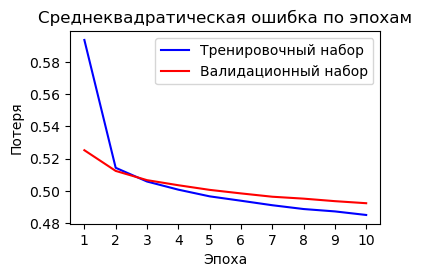

In [28]:
plot_losses(train_history, val_history, "MSE")

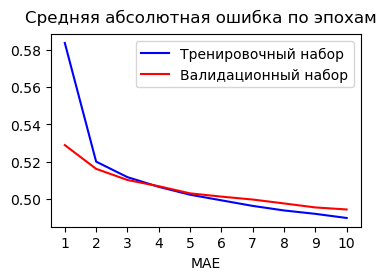

In [29]:
plot_metrics(train_history, val_history)

## Тестирование на видео

In [45]:
model.eval()

def get_distance_between(im1:np.ndarray, im2:np.ndarray, coord1:np.ndarray=None, coord2:np.ndarray=None):
    im1t = val_tforms(Image.fromarray(im1)).unsqueeze(0).to(device)
    im2t = val_tforms(Image.fromarray(im2)).unsqueeze(0).to(device)
    
    im1_emb = model.encoder(im1t).detach().cpu().numpy().ravel()
    im2_emb = model.encoder(im2t).detach().cpu().numpy().ravel()

    if type(coord1) is np.ndarray and type(coord2) is np.ndarray:
        im1_emb = np.concatenate((im1_emb, coord1))
        im2_emb = np.concatenate((im2_emb, coord2))

    return np.linalg.norm(im1_emb - im2_emb, 2)

def pick_person(frame:np.ndarray, bbox:np.ndarray):
    y, x, h, w = bbox
    return frame[x:x + w, y:y + h]

def update_person_box_emb_dist(cur_frame:np.ndarray, past_frame:np.ndarray, prev_boxes:dict, newly_boxes:list):
    new_people_idx = dict()
    distances = dict()
    for box in newly_boxes:
        potential_index = dict()
        cur_person_img = pick_person(cur_frame, box)
        for idx in prev_boxes:
            past_person_img = pick_person(past_frame, prev_boxes[idx])
            dist = get_distance_between(cur_person_img, past_person_img)
            if idx in new_people_idx and (distances[idx] < dist):
                continue
            potential_index[idx] = dist
        if len(potential_index) > 0:
            min_index = min(potential_index, key=potential_index.get)
            new_people_idx[min_index] = box
            distances[min_index] = potential_index[min_index]
    for idx in prev_boxes:
        if not (idx in new_people_idx): #not in new_box_index either
            new_people_idx[idx] = prev_boxes[idx]
    return new_people_idx

In [48]:
im1, c1 = frame_people[0]
im2, c2 = frame_people[1]
get_distance_between(im1, im2, c1, c2)

298.2577059202683

In [52]:
codec_code = cv.VideoWriter.fourcc(*'h264')
writer = cv.VideoWriter("../0756_nn_tracking.mp4", codec_code, 30.0, (1280, 720))
writer.isOpened()

True

In [53]:
colors = np.random.default_rng().integers(0, 256, (1000, 3), dtype='uint8')
vidcap = cv.VideoCapture("../original_vids/0756-30fps.mp4")
fps = vidcap.get(cv.CAP_PROP_FPS)
total_frames = int(vidcap.get(cv.CAP_PROP_FRAME_COUNT))

vid_width = vidcap.get(cv.CAP_PROP_FRAME_WIDTH)
vid_height = vidcap.get(cv.CAP_PROP_FRAME_HEIGHT)

current_frame = 0
success,frame = vidcap.read()
if not success:
    print("error in video", vid_path)
with open("../alphapose_res/0756_alpha.json", "r") as ann_file:
    anns = json.load(ann_file)
past_frame = None
past_frame_boxes = None
cur_frame_boxes = []
for person in tqdm(anns):
    if person['image_id'] > current_frame:
        # print("cur", cur_frame_boxes)
        # print("past", past_frame_boxes)
        # if current_frame + 1 == 5: break
        if type(past_frame) is np.ndarray and type(past_frame_boxes) is np.ndarray:
            past_frame_boxes = update_person_box_emb_dist(
                frame, past_frame, past_frame_boxes, cur_frame_boxes)
        else:
            past_frame_boxes = {idx:pic for idx, pic in enumerate(cur_frame_boxes)}
        annotated_img = vis_box_tracking(frame, past_frame_boxes, colors)
        writer.write(annotated_img)
        past_frame = frame
        success,frame = vidcap.read()
        if not success:
            print("error in video", "../original_vids/0756-30fps.mp4")
            break
        current_frame += 1
        cur_frame_boxes = []
    person_bbox = np.array(list(map(round, person['box'])))
    cur_frame_boxes.append(person_bbox)
    #cur_frame_people.append(person_img)
vidcap.release()
writer.release()

 99%|█████████████████████████████████████████████████████████████████████████▎| 13304/13419 [00:04<00:00, 3040.33it/s]


error in video ../original_vids/0756-30fps.mp4


In [51]:
vidcap.release()
writer.release()